In [1]:
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import networkx as nx
import community
import pandas as pd

import numpy as np

In [3]:
import imp
tools = imp.load_source('tools', '../tools.py')

from tools import  write_to_file, test_kruskal

In [4]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.lines as lines

font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [5]:
ipd      = pd.read_json('../data/pd_November_2018_clean.json')
anarchy  = pd.read_json('../data/anarchy_November_2018_clean.json')
auction  = pd.read_json('../data/auction_November_2018_clean.json')

dataframes = [ipd, auction, anarchy]

In [6]:
periods = []
for data in dataframes:
    period = np.sort(data['date'].unique())
    period = period[~np.isnan(period)]
    periods.append(period[1:])   

 Collaborativeness 
---------------------------

In [7]:
graphs = []
for filename in ['pd_graph.gml', 'auction_graph.gml', 'anarchy_graph.gml']:
    graphs.append(nx.read_gml('../data/networks/{}'.format(filename)))

Illustrating co-authors network
------------------------

**Use Gephi**

Network Metrics
-----------------------

In [8]:
number_edges = [nx.number_of_edges(G) for G in graphs]
number_nodes = [nx.number_of_nodes(G) for G in graphs]

In [9]:
for filename, metric in zip(['pd_edges.txt', 'pd_unique_authors.txt'], [number_edges[0], number_nodes[0]]):
    write_to_file(filename=filename, metric=metric)

Collaborative Behaviour
-----------------------------

**Network Metrics**

In [10]:
isolated_authors = [len(list(nx.isolates(G))) for G in graphs]
isolated_authors

[157, 210, 4]

In [11]:
isolated_authors_percentage = [np.round(isolated / nodes, 3) 
                               for isolated, nodes in zip(isolated_authors, number_nodes)]

In [12]:
number_connected_components = [nx.number_connected_components(G) for G in graphs]

In [13]:
subgraphs = [list(nx.connected_component_subgraphs(G)) for G in graphs]

In [14]:
largest_cc = [len(max(nx.connected_components(G), key=len)) for G in graphs]

In [15]:
clustering_coeff = [round(nx.average_clustering(G), 3) for G in graphs]

In [16]:
degree_distributions = [sorted([d for n, d in G.degree()], reverse=True) for G in graphs]
av_degree = [np.round(np.mean(degree), 3) for degree in degree_distributions]

In [17]:
communities = [community.best_partition(G) for G in graphs]
modularities = [community.modularity(partition=communities[i], graph=G) for i, G in enumerate(graphs)]

In [18]:
filenames = ['isolated_authors.txt', 'isolated_authors_percentage.txt', 'number_of_connected.txt',
             "largest_cc.txt", "av_degree.txt", "clustering_coeff.txt", "modularity_pd.txt"]

In [19]:
for i, metric in enumerate([isolated_authors, isolated_authors_percentage, number_connected_components, largest_cc,
                            av_degree, clustering_coeff, modularities]):
    write_to_file(filenames[i], metric[0])

**Degree Distribution**

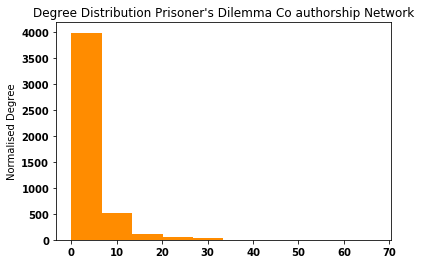

In [20]:
fig = plt.figure()

plt.hist(degree_distributions[0],  color='darkorange')
plt.ylabel('Normalised Degree')
plt.title("Degree Distribution Prisoner's Dilemma Co authorship Network")

plt.savefig('../../assets/images/pd_degree_distribution.pdf')

In [21]:
colors = ['darkorange', 'darkred', 'darkgreen']

In [22]:
labels = [r'$G_1$', r'$G_2$', r'$G_3$']

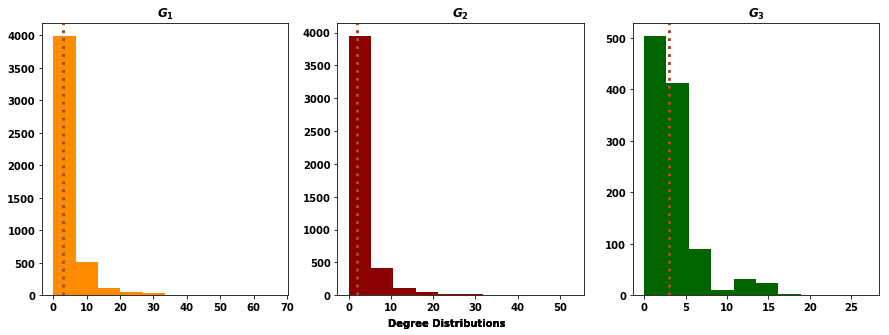

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, dstr in enumerate(degree_distributions): 
    axes[i].hist(dstr, color=colors[i]);
    axes[i].axvline(np.median(dstr), color='sienna', linestyle=':', linewidth=3, label='median')
    axes[i].title.set_text(labels[i])
    
    fig.text(0.5, 0.04, 'Degree Distributions', ha='center', fontsize=10)
    
plt.savefig('../../assets/images/networks_ditributions.pdf')

In [24]:
test_kruskal(degree_distributions)

5.285329162268849e-23 The null hypothesis can be rejected.


**Comparison between fields**

In [25]:
frame = {'# Isolated': isolated_authors, '% Isolated': isolated_authors_percentage,
         '# Connected Components': number_connected_components, 'Largest cc': largest_cc,
         'Clustering': clustering_coeff, 'Av. Degree': av_degree, 'Modularity': modularities,
         '# Edges': number_edges, '# Nodes': number_nodes}

In [26]:
table = pd.DataFrame.from_dict(frame).round(3)
table.index= ["Prisoner's Dilemma", "Auction Games", "Price of Anarchy"]

In [27]:
table

,# Connected Components,# Edges,# Isolated,# Nodes,% Isolated,Av. Degree,Clustering,Largest cc,Modularity
Prisoner's Dilemma,1027,9882,157,4713,0.033,4.194,0.685,1457,0.930
Auction Games,947,7740,210,4567,0.046,3.390,0.595,2076,0.892
Price of Anarchy,193,1910,4,1072,0.004,3.563,0.705,421,0.948


In [28]:
write_to_file(metric=table.to_latex(), filename="network_comparison.tex")

Cumulative Graphs
---------

In [29]:
import glob

In [30]:
number_of_files = len(list(glob.glob('../data/networks/G_pd_*.gml')))

In [31]:
cumulative_graphs = []
for i in range(number_of_files):
    cumulative_graphs.append(nx.read_gml('../data/networks/G_pd_{}.gml'.format(i)))

In [32]:
degree_points, largest_cc_points, number_of_cc_points, number_of_nodes, percentage_number = [], [], [], [], []
for G in cumulative_graphs:
    degree = sorted([d for n, d in G.degree()], reverse=True)
    largest_cc_points.append(len(max(nx.connected_components(G), key=len)))
    degree_points.append(np.mean(degree))
    number_of_cc_points.append(nx.number_connected_components(G))
    number_of_nodes.append(G.number_of_nodes())
    
    percentage_number.append(np.round(G.number_of_nodes() / number_nodes[0], 2))

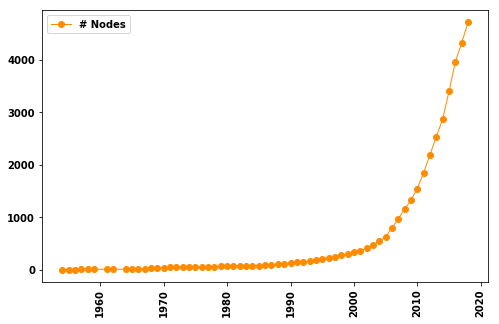

In [33]:
fig = plt.figure(figsize=(8, 5))
plt.plot(periods[0], number_of_nodes, '-o', linewidth=1, label='# Nodes', color=colors[0],)
plt.xticks(rotation=90);
plt.legend();

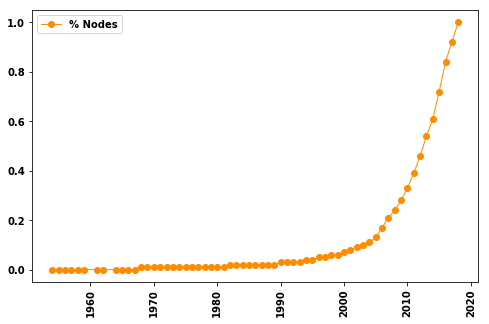

In [34]:
fig = plt.figure(figsize=(8, 5))
plt.plot(periods[0], percentage_number, '-o', linewidth=1, label='% Nodes', color=colors[0],)
plt.xticks(rotation=90);
plt.legend();

plt.savefig('../../assets/images/nodes_percentage_over_time.pdf')

In [35]:
other_topics_files = [len(list(glob.glob('../data/networks/G_auction_*.gml')))]
other_topics_files.append(len(list(glob.glob('../data/networks/G_anarchy_*.gml'))))

In [36]:
auction_graphs = [nx.read_gml('../data/networks/G_auction_{}.gml'.format(i)) for i in range(other_topics_files[0])]
anarchy_graphs = [nx.read_gml('../data/networks/G_anarchy_{}.gml'.format(i)) for i in range(other_topics_files[1])]

In [37]:
degree_points_auction, largest_cc_points_auction, number_of_cc_points_auction, number_of_nodes_auction = [], [], [], []
percentage_number_auction = []
for G in auction_graphs:
    degree = sorted([d for n, d in G.degree()], reverse=True)
    
    largest_cc_points_auction.append(len(max(nx.connected_components(G), key=len)))
    degree_points_auction.append(np.mean(degree))
    number_of_cc_points_auction.append(nx.number_connected_components(G))
    number_of_nodes_auction.append(G.number_of_nodes())
    
    percentage_number_auction.append(np.round(G.number_of_nodes() / number_nodes[1], 2))

In [38]:
degree_points_anarchy, largest_cc_points_anarchy, number_of_cc_points_anarchy, number_of_nodes_anarchy = [], [], [], []
percentage_number_anarchy = []
for G in anarchy_graphs:
    degree = sorted([d for n, d in G.degree()], reverse=True)
    
    largest_cc_points_anarchy.append(len(max(nx.connected_components(G), key=len)))
    degree_points_anarchy.append(np.mean(degree))
    number_of_cc_points_anarchy.append(nx.number_connected_components(G))
    number_of_nodes_anarchy.append(G.number_of_nodes())
    
    percentage_number_anarchy.append(np.round(G.number_of_nodes() / number_nodes[2], 2))

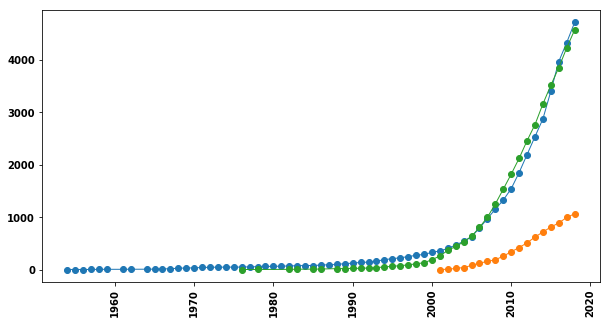

In [39]:
fig = plt.figure(figsize=(10, 5))
plt.plot(periods[0], number_of_nodes, '-o', linewidth=1, label='Number of nodes')
plt.plot(periods[2], number_of_nodes_anarchy, '-o', linewidth=1, label='Number of nodes')
plt.plot(periods[1], number_of_nodes_auction, '-o', linewidth=1, label='Number of nodes')

plt.xticks(rotation=90);

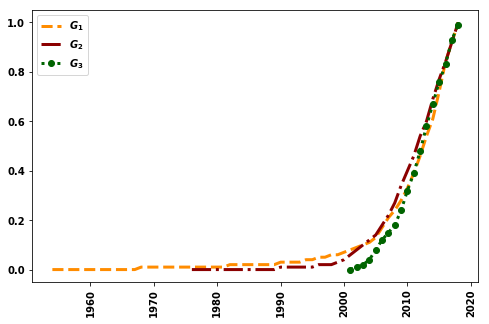

In [40]:
fig = plt.figure(figsize=(8, 5))
plt.plot(periods[0], percentage_number, '--', linewidth=3, label='$G_1$', color=colors[0])
plt.plot(periods[1], percentage_number_auction, '-.', linewidth=3, label='$G_2$', color=colors[1])
plt.plot(periods[2], percentage_number_anarchy, ':o', linewidth=3, label='$G_3$', color=colors[2])

plt.xticks(rotation=90);
plt.legend();

plt.savefig('../../assets/images/percentage_networks_nodes.pdf')

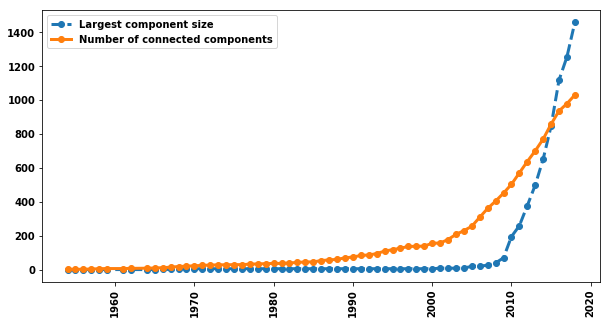

In [41]:
fig = plt.figure(figsize=(10, 5))
plt.plot(periods[0], largest_cc_points, '--o', linewidth=3, label='Largest component size');
plt.plot(periods[0], number_of_cc_points, '-o', linewidth=3, label='Number of connected components');

plt.xticks(rotation=90);
plt.legend();

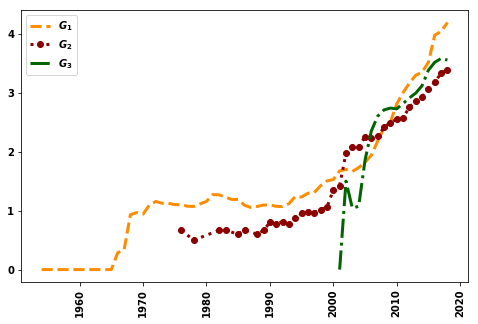

In [42]:
fig = plt.figure(figsize=(8, 5))
plt.plot(periods[0], degree_points, '--', label='$G_1$', linewidth=3, color=colors[0]);
plt.plot(periods[1], degree_points_auction, ':o', label='$G_2$', linewidth=3, color=colors[1]);
plt.plot(periods[2], degree_points_anarchy, '-.', label='$G_3$', linewidth=3, color=colors[2]);

plt.xticks(rotation=90);
plt.legend();


plt.savefig('../../assets/images/degrees_over_time.pdf')

**Metrics over time**

In [43]:
isolated_authors = [len(list(nx.isolates(G))) for G in cumulative_graphs]

In [44]:
isolated_authors_percentage = [isolated / nodes for isolated, nodes in zip(isolated_authors, number_of_nodes)]

In [45]:
number_connected_components = [nx.number_connected_components(G) for G in cumulative_graphs]

In [46]:
largest_cc = [len(max(nx.connected_components(G), key=len)) for G in cumulative_graphs]

In [47]:
clustering_coeff = [round(nx.average_clustering(G), 3) for G in cumulative_graphs]

In [48]:
degree_distributions = [sorted([d for n, d in G.degree()], reverse=True) for G in cumulative_graphs]
av_degree = [np.mean(degree) for degree in degree_distributions]

In [49]:
communities = [community.best_partition(G) for G in cumulative_graphs]

In [50]:
modularities = []
for i, G in enumerate(cumulative_graphs):
    try:
        modularities.append(community.modularity(partition=communities[i],graph=G))
    except ValueError:
        modularities.append('-')

In [51]:
frame = {'# Isolated': isolated_authors, '% Isolated': isolated_authors_percentage,
         '# Connected Components': number_connected_components, 'Largest cc': largest_cc,
         'Clustering': clustering_coeff, 'Av. Degree': av_degree, 'Modularity': modularities,
         '# Nodes': number_of_nodes}

In [52]:
import json

In [53]:
with open("../../assets/periods_dictionary.json") as json_file:
    periods_dictionary  = json.load(json_file)


In [54]:
table = pd.DataFrame.from_dict(frame).round(2)
table.index = [periods_dictionary["Period {}".format(i)] for i,_ in enumerate(table.index)]

In [55]:
table.head()

,# Connected Components,# Isolated,# Nodes,% Isolated,Av. Degree,Clustering,Largest cc,Modularity
1954 - 1950,3,3,3,1.0,0.0,0.0,1,-
1954 - 1955,2,2,2,1.0,0.0,0.0,1,-
1955 - 1956,3,3,3,1.0,0.0,0.0,1,-
1956 - 1957,4,4,4,1.0,0.0,0.0,1,-
1957 - 1958,6,6,6,1.0,0.0,0.0,1,-


In [56]:
write_to_file(metric=table.to_latex(), filename="cumulative_graphs_table.tex")